In [1]:
# Import Libraries and Configure Environment
import sys
import os

# Assuming ROS is installed in the default location
ros_path = '/opt/ros/noetic/lib/python3/dist-packages'
if ros_path not in sys.path:
    sys.path.append(ros_path)

# Add your ROS workspace
workspace_path = os.path.join(os.environ['HOME'], 'Desktop/RT1_2/catkin_ws/devel/lib/python3/dist-packages')
if workspace_path not in sys.path:
    sys.path.append(workspace_path)

# Importing necessary libraries
import rospy
from geometry_msgs.msg import Point, Pose, Twist
from nav_msgs.msg import Odometry
import actionlib
from assignment_2_2023.msg import Vel, PlanningAction, PlanningGoal, PlanningResult
from actionlib_msgs.msg import GoalStatus
import ipywidgets as widgets
from IPython.display import display, clear_output
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation


In [2]:
# Initialize global variables
x_data = []
y_data = []
reached_goals = 0
missed_goals = 0

# Define goal handling functions
def set_goal(b):
    goal_x = goal_x_widget.value
    goal_y = goal_y_widget.value
    rospy.set_param('/des_pos_x', goal_x)
    rospy.set_param('/des_pos_y', goal_y)
    new_goal = PlanningGoal()
    new_goal.target_pose.pose.position.x = goal_x
    new_goal.target_pose.pose.position.y = goal_y
    goal_action_client.send_goal(new_goal, done_cb=goal_done_cb)
    rospy.loginfo(f"Set new goal: ({goal_x}, {goal_y})")

def cancel_goal(b):
    goal_action_client.cancel_goal()
    rospy.loginfo("Goal cancelled")

def goal_done_cb(state, result):
    global reached_goals, missed_goals
    if state == GoalStatus.SUCCEEDED:
        reached_goals += 1
    else:
        missed_goals += 1
    update_goal_stats()

def update_goal_stats():
    goal_stats_text.set_text(f"Reached Goals: {reached_goals}\nMissed Goals: {missed_goals}")
    ax2.figure.canvas.draw()


In [3]:
# Initialize global variables
x_data = []
y_data = []
reached_goals = 0
missed_goals = 0

# Define goal handling functions
def set_goal(b):
    goal_x = goal_x_widget.value
    goal_y = goal_y_widget.value
    rospy.set_param('/des_pos_x', goal_x)
    rospy.set_param('/des_pos_y', goal_y)
    new_goal = PlanningGoal()
    new_goal.target_pose.pose.position.x = goal_x
    new_goal.target_pose.pose.position.y = goal_y
    goal_action_client.send_goal(new_goal, done_cb=goal_done_cb)
    rospy.loginfo(f"Set new goal: ({goal_x}, {goal_y})")

def cancel_goal(b):
    goal_action_client.cancel_goal()
    rospy.loginfo("Goal cancelled")

def goal_done_cb(state, result):
    global reached_goals, missed_goals
    if state == GoalStatus.SUCCEEDED:
        reached_goals += 1
    else:
        missed_goals += 1
    update_goal_stats()

def update_goal_stats():
    goal_stats_text.set_text(f"Reached Goals: {reached_goals}\nMissed Goals: {missed_goals}")
    ax2.figure.canvas.draw()


In [4]:
# Initialize ROS node and action client with debug information
print("Initializing ROS node...")
rospy.init_node('target_goal_manager', anonymous=True)
print("ROS node initialized.")

print("Creating action client...")
goal_action_client = actionlib.SimpleActionClient('/reaching_goal', PlanningAction)
print("Waiting for action server to start...")

# Wait for the action server to start with a longer timeout
server_started = goal_action_client.wait_for_server(timeout=rospy.Duration(30.0))
if not server_started:
    print("Error: Action server not available.")
else:
    print("Action server started.")


Initializing ROS node...
ROS node initialized.
Creating action client...
Waiting for action server to start...
Error: Action server not available.


In [5]:
# Create widgets for displaying position and velocity
pos_x_widget = widgets.FloatText(description='Pos X')
pos_y_widget = widgets.FloatText(description='Pos Y')
vel_x_widget = widgets.FloatText(description='Vel X')
vel_z_widget = widgets.FloatText(description='Vel Z')


In [6]:
# Create widgets for setting and canceling goals
goal_x_widget = widgets.FloatText(description='Goal X')
goal_y_widget = widgets.FloatText(description='Goal Y')
set_goal_button = widgets.Button(description='Set Goal')
cancel_goal_button = widgets.Button(description='Cancel Goal')

# Attach functions to buttons
set_goal_button.on_click(set_goal)
cancel_goal_button.on_click(cancel_goal)


In [7]:
# Display the widgets
display(pos_x_widget, pos_y_widget, vel_x_widget, vel_z_widget)
display(goal_x_widget, goal_y_widget, set_goal_button, cancel_goal_button)


FloatText(value=0.0, description='Pos X')

FloatText(value=0.0, description='Pos Y')

FloatText(value=0.0, description='Vel X')

FloatText(value=0.0, description='Vel Z')

FloatText(value=0.0, description='Goal X')

FloatText(value=0.0, description='Goal Y')

Button(description='Set Goal', style=ButtonStyle())

Button(description='Cancel Goal', style=ButtonStyle())

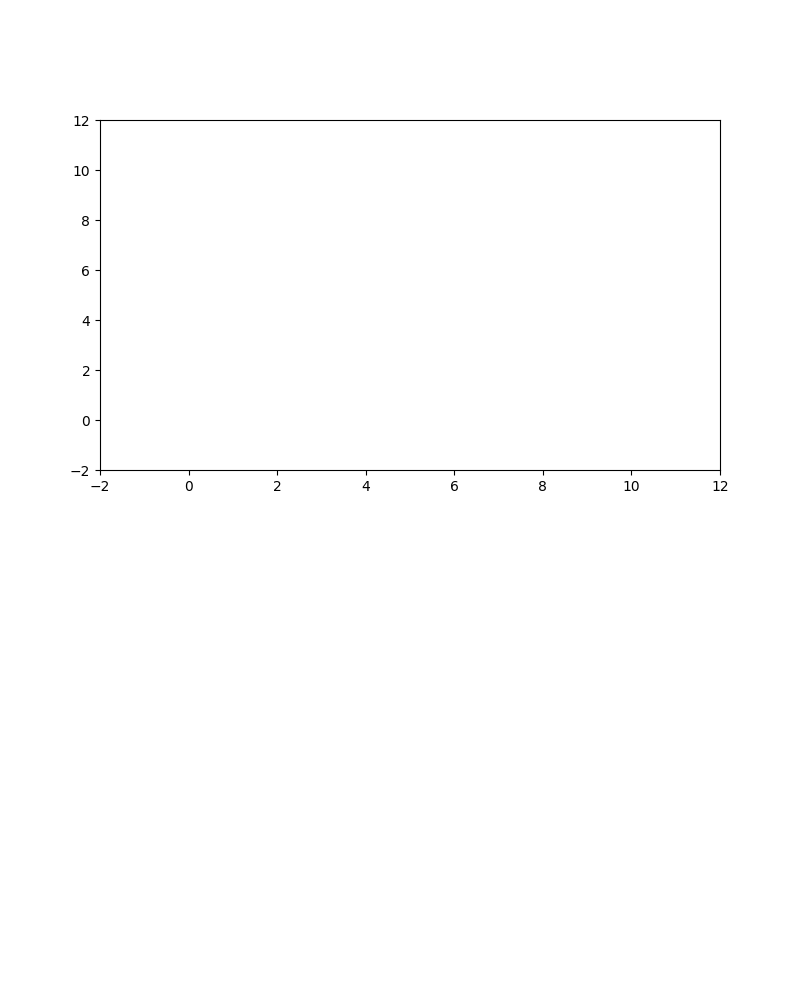

In [8]:
# Set up the plot
%matplotlib widget
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 10))
ax1.set_xlim(-2, 12)
ax1.set_ylim(-2, 12)
line, = ax1.plot([], [], 'r-')
goal_stats_text = ax2.text(0.5, 0.5, "", ha='center', va='center', fontsize=12)
ax2.axis('off')

# Update the plot with odom data
def update_plot(frame):
    line.set_xdata(x_data)
    line.set_ydata(y_data)
    ax1.figure.canvas.draw()

# Initialize FuncAnimation
ani = FuncAnimation(fig, update_plot, blit=False)


In [9]:
# Odometry callback
def odom_callback(odom_data):
    position = odom_data.pose.pose.position
    linear_velocity = odom_data.twist.twist.linear
    angular_velocity = odom_data.twist.twist.angular

    x_data.append(position.x)
    y_data.append(position.y)
    pos_x_widget.value = position.x
    pos_y_widget.value = position.y
    vel_x_widget.value = linear_velocity.x
    vel_z_widget.value = angular_velocity.z

# Subscribe to Odometry data
rospy.Subscriber("/odom", Odometry, odom_callback)


In [ ]:
# Keep the node running
rospy.spin()
